In [1]:
import numpy as np 
from tqdm import tqdm
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
from qutip import *
qutip.__version__

'4.4.1'

In [10]:
#operators and gates
sx = sigmax() * 0.5
sy = sigmay() * 0.5
sz = sigmaz() * 0.5
electron_x = tensor(sx, qeye(2))
electron_y = tensor(sy, qeye(2))
electron_z = tensor(sz, qeye(2))
carbon_x = tensor(qeye(2), sx)
carbon_y = tensor(qeye(2), sy)
carbon_z = tensor(qeye(2), sz)

H_xx_yy = electron_x * carbon_x + electron_y * carbon_y
flip_flop_evo = lambda theta: (-1j * H_xx_yy * theta).expm()
# Rabi_evo = lambda theta: (-1j * carbon_x * theta).expm()
Carbon_phase_accum = lambda theta: (-1j * sz * theta).expm()

def rabi_evo(theta, phi):
    H = carbon_x * np.cos(phi) + carbon_y * np.sin(phi)
    return (-1j * H * theta).expm()


def flip_flop_12(carbon_state=Qobj([[1.,0.],[0.,0.]]), flip_flop_theta=np.pi, carbon_phase_phi=0,
                rabi_theta=np.pi/2, rabi_phi=0., reset=True):
    """
    description:
        Simulation of 12th measurement FF->Rabi 13C->electron reset->FF
    
    params:
        initial_carbon_state: Qobj -- initial state of carbon spin
        flip_flop_theta: float -- Length of pulsed polarization transfer
        carbon_phase_phi: float -- phase accumulated during reinitialization of electron state
        rabi_theta: float -- Length of carbon Rabi oscilations
    
    """
    # state preparation
    electron_state = Qobj([[0.5,0.5],[0.5,0.5]])
    state = tensor(electron_state, carbon_state)
    
    # 1st flipflop evolution
    U_ff = flip_flop_evo(flip_flop_theta)
    state = U_ff * state * U_ff.dag()
    
    flipped_electron_state = state.ptrace(0)
    flipped_carbon_state = state.ptrace(1)
    
    # Carbon Rabi oscilation
    U_Rabi = rabi_evo(rabi_theta, rabi_phi)
    state = U_Rabi * state * U_Rabi.dag()
    
    rabi_electron_state = state.ptrace(0)
    rabi_carbon_state = state.ptrace(1)
    
    if reset:
        # electron reinitialization
        U_C_phase = Carbon_phase_accum(carbon_phase_phi)
        rabi_carbon_state = U_C_phase * rabi_carbon_state * U_C_phase.dag()
        state = tensor(Qobj([[1.,0.],[0.,0.]]), rabi_carbon_state)
    
    # 2nd flipflop evolution
    state = U_ff * state * U_ff.dag()

    # readout 
    final_electron_state = state.ptrace(0)
    final_carbon_state = state.ptrace(1)
    
    return {'1st FF': [flipped_electron_state, flipped_carbon_state],
           'Rabi': [rabi_electron_state, rabi_carbon_state],
           '2nd FF': [final_electron_state, final_carbon_state]}


def time1_synchronization(carbon_state=Qobj([[1.,0.],[0.,0.]]), flip_flop_theta=np.pi, carbon_phase_phi=0):
    
    # state preparation
    electron_state = Qobj([[0.5,0.5],[0.5,0.5]])
    state = tensor(electron_state, carbon_state)
    
    # 1st flipflop evolution
    U_ff = flip_flop_evo(flip_flop_theta)
    state = U_ff * state * U_ff.dag()
    
    flipped_electron_state = state.ptrace(0)
    flipped_carbon_state = state.ptrace(1)
    
    U_C_phase = Carbon_phase_accum(carbon_phase_phi)
    rabi_carbon_state = U_C_phase * flipped_carbon_state * U_C_phase.dag()
    state = tensor(Qobj(flipped_electron_state, rabi_carbon_state))
    
    # 2nd flipflop evolution
    state = U_ff * state * U_ff.dag()

    # readout 
    final_electron_state = state.ptrace(0)
    final_carbon_state = state.ptrace(1)
    
    return {'1st FF': [flipped_electron_state, flipped_carbon_state],
           '2nd FF': [final_electron_state, final_carbon_state]}


In [11]:
electron_polarization_C_down = []
carbon_phase_range = np.arange(100) * np.pi / 100
for carbon_phase in carbon_phase_range:
    results = time1_synchronization(carbon_phase_phi=carbon_phase)
    readout_electron, readout_carbon = results['2nd FF']
    electron_polarization_C_down.append((sigmaz() * readout_electron).tr())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plt.figure(figsize=(10, 7))
size = 30 
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('figure', titlesize=size)

plt.plot(rabi_phi_range, electron_polarization_C_up)
plt.plot(rabi_phi_range, electron_polarization_C_down)

plt.xlabel(r'Rabi phase',fontsize=size)
plt.ylabel(r'Polarization')

plt.grid()

In [58]:
electron_state_test = Qobj([[0.5,0.5],[0.5,0.5]])
carbon_state_test = Qobj([[1.,0.],[0.,0.]])
print(expect(carbon_state_test,sz))
state_test = tensor(electron_state_test, carbon_state_test)

U_ff_test = flip_flop_evo(np.pi)
state_test = U_ff_test * state_test * U_ff_test.dag()
state_test.ptrace(1)
print(expect(state_test,carbon_y))
state_test.ptrace(1) * state_test.ptrace(1), state_test.ptrace(1)



0.5
-0.5


(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5+0.j  0. +0.5j]
  [0. -0.5j 0.5+0.j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5+0.j  0. +0.5j]
  [0. -0.5j 0.5+0.j ]])

## Final electron polarization with reset

In [29]:
points_number = 100
rabi_phi_range = np.arange(points_number) * 2 * np.pi / points_number
electron_polarization_C_up = []
electron_polarization_C_down = []
carbon_state_after_rabi_C_up = []
carbon_state_after_rabi_C_down = []

for rabi_phi in tqdm(rabi_phi_range):
    results = flip_flop_12(carbon_state=Qobj([[1.,0.],[0.,0.]]), rabi_theta=np.pi/2, rabi_phi=rabi_phi,
                           carbon_phase_phi=0., flip_flop_theta=np.pi)
    readout_electron, readout_carbon = results['2nd FF']
    rabi_electron, rabi_carbon = results['Rabi']
    
    electron_polarization_C_up.append((sigmaz() * readout_electron).tr())
    carbon_state_after_rabi_C_up.append((sigmaz() * rabi_carbon).tr())
                           
    results = flip_flop_12(carbon_state=Qobj([[0.,0.],[0.,1.]]), rabi_theta=np.pi/2, rabi_phi=rabi_phi,
                           carbon_phase_phi=0., flip_flop_theta=np.pi)
    readout_electron, readout_carbon = results['2nd FF']
    rabi_electron, rabi_carbon = results['Rabi']
    
    electron_polarization_C_down.append((sigmaz() * readout_electron).tr())
    carbon_state_after_rabi_C_down.append((sigmaz() * rabi_carbon).tr())
    

100%|██████████| 100/100 [00:01<00:00, 74.86it/s]


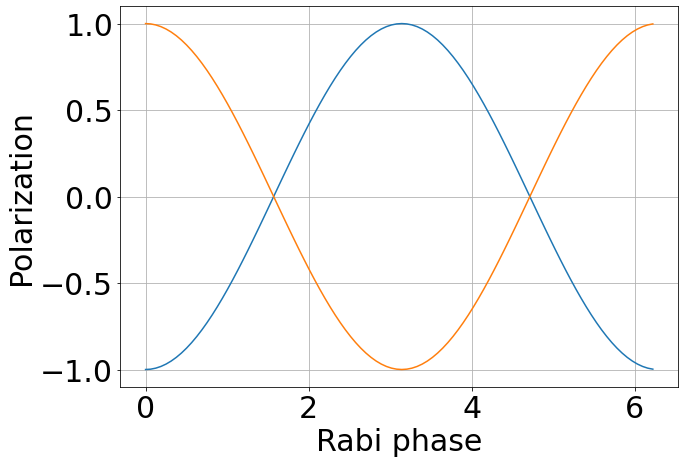

In [30]:
plt.figure(figsize=(10, 7))
size = 30 
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('figure', titlesize=size)

plt.plot(rabi_phi_range, electron_polarization_C_up)
plt.plot(rabi_phi_range, electron_polarization_C_down)

plt.xlabel(r'Rabi phase',fontsize=size)
plt.ylabel(r'Polarization')

plt.grid()

## Carbon state after Rabi

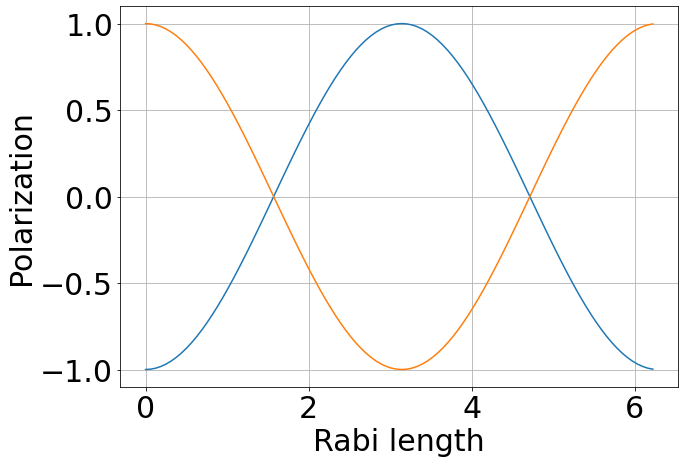

In [26]:
plt.figure(figsize=(10, 7))
size = 30 
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('figure', titlesize=size)

plt.plot(rabi_phi_range, carbon_state_after_rabi_C_up)
plt.plot(rabi_phi_range, carbon_state_after_rabi_C_down)

plt.xlabel(r'Rabi length', fontsize=size)
plt.ylabel(r'Polarization')

plt.grid()

## Without reset

In [31]:
points_number = 100
rabi_phi_range = np.arange(points_number) * 2 * np.pi / points_number
electron_polarization_C_up = []
electron_polarization_C_down = []
carbon_state_after_rabi_C_up = []
carbon_state_after_rabi_C_down = []

for rabi_phi in tqdm(rabi_phi_range):
    results = flip_flop_12(carbon_state=Qobj([[1.,0.],[0.,0.]]), rabi_theta=np.pi/2, rabi_phi=rabi_phi,
                           carbon_phase_phi=0., flip_flop_theta=np.pi, reset=False)
    readout_electron, readout_carbon = results['2nd FF']
    rabi_electron, rabi_carbon = results['Rabi']
    
    electron_polarization_C_up.append((sigmaz() * readout_electron).tr())
    carbon_state_after_rabi_C_up.append((sigmaz() * rabi_carbon).tr())
                           
    results = flip_flop_12(carbon_state=Qobj([[0.,0.],[0.,1.]]), rabi_theta=np.pi/2, rabi_phi=rabi_phi,
                           carbon_phase_phi=0., flip_flop_theta=np.pi, reset=False)
    readout_electron, readout_carbon = results['2nd FF']
    rabi_electron, rabi_carbon = results['Rabi']
    
    electron_polarization_C_down.append((sigmaz() * readout_electron).tr())
    carbon_state_after_rabi_C_down.append((sigmaz() * rabi_carbon).tr())

100%|██████████| 100/100 [00:01<00:00, 91.86it/s]


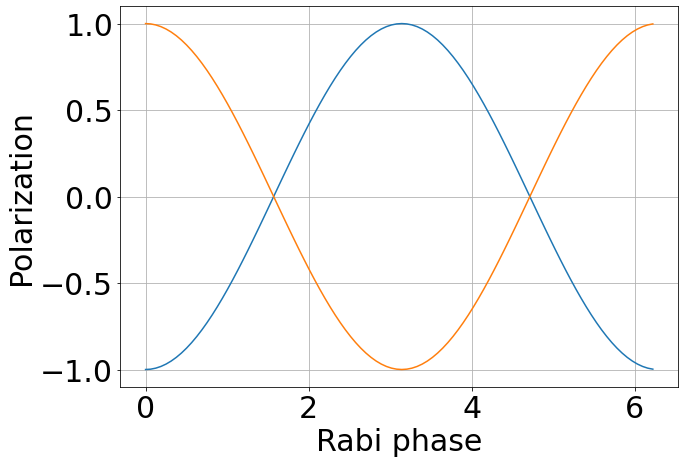

In [32]:
plt.figure(figsize=(10, 7))
size = 30 
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('figure', titlesize=size)

plt.plot(rabi_phi_range, electron_polarization_C_up)
plt.plot(rabi_phi_range, electron_polarization_C_down)

plt.xlabel(r'Rabi phase',fontsize=size)
plt.ylabel(r'Polarization')

plt.grid()